<a href="https://colab.research.google.com/github/rishabhgupta592/textClassificationChatbot/blob/main/textClassificationOn_SmallQueryForChatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install sentence-transformers

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 2.0MB 8.1MB/s 
     |████████████████████████████████| 1.2MB 38.1MB/s 
     |████████████████████████████████| 3.2MB 46.6MB/s 
     |████████████████████████████████| 890kB 46.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.3-cp37-none-any.whl size=114277 sha256=955afbc7b43b40e9adb0c13e45804b5bce710ebef2fae72458cd20eb3612a323
  Stored in directory: /root/.cache/pip/wheels/c8/0d/fa/4e28cf045da4781344e7972befb2fdf306051b225bfc290187
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f6c6e386f1417dc340059c883b5f0fd560f6150a3b1c708d7ebc19206aabf9ae
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
data = pd.read_csv("train_data.csv",sep="\t")
data.head(5)

,message,label
0,this company is shitty,company
1,culture in the company is really bad,culture
2,its a very badass culture in the company,culture
3,My boss does not trust me,trust
4,I have zero trust on my manager,trust


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-base') 
# model = SentenceTransformer('paraphrase-distilroberta-base-v1') # very poor accuracy
"""
{
 "Train Sample Count": 913,
 "Test Sample Count": 229,
 "Num of Classes": 3,
 "Num of Features": 768,
 "kernel": "rbf",
 "Training Accuracy": "0.705",
 "Test Accuracy": "0.699",
 "Precision": "0.904",
 "Recall": "0.926"
}
"""


'\n{\n "Train Sample Count": 913,\n "Test Sample Count": 229,\n "Num of Classes": 3,\n "Num of Features": 768,\n "kernel": "rbf",\n "Training Accuracy": "0.705",\n "Test Accuracy": "0.699",\n "Precision": "0.904",\n "Recall": "0.926"\n}\n'

In [ ]:
subset = data[data['label'].isin( ["manager", "company", "stress"])]


In [ ]:
subset['word_length'] = subset.message.apply(lambda i: len(i.split()))
subset = subset[subset.word_length <30]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def process(text):
    text = text.lower()
    # text = word_tokenize(text)
    # Final_words = []
    # Initializing WordNetLemmatizer()
    # word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    # for word, tag in pos_tag(text):
        # Below condition is to check for Stop words and consider only alphabets
        # if word not in stopwords.words('english') and word.isalpha():
            # word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            # Final_words.append(word_Final)
    # return " ".join(Final_words)
    return text

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
subset['processed_message'] = subset["message"].progress_apply(process)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
text = np.array(subset['processed_message'])
category = np.array(subset['label'])
# build train and test datasets

# Train/test splitting 
from sklearn.model_selection import train_test_split    
Train_X, Test_X, Train_Y, Test_Y = train_test_split(text, category, test_size=0.2, random_state=101)

In [ ]:
query_embedding = model.encode('How big is London')
query_embedding.shape

(768,)

In [ ]:
train_x_feature  = model.encode(Train_X)

In [ ]:
test_x_feature = model.encode(Test_X)

In [ ]:
train_x_feature.shape

(913, 768)

In [ ]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

param = {'C': [1, 10, 100, 1000], 'kernel': ('poly', 'rbf'), 'gamma':['auto', 1e-3, 1e-4]}
# clf = make_pipeline(StandardScaler(with_mean=False), GridSearchCV(SVC(class_weight='balanced'),param_grid=param,refit=True))
clf = grid = GridSearchCV(SVC(class_weight='balanced'), param_grid=param, refit = True, verbose = 3) 
# Set the parameters by cross-validation
clf.fit(train_x_feature, Train_Y)
# print best parameter after tuning 
print(clf.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(clf.best_estimator_) 
# SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
# SVM.fit(train_x_feature,Train_Y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=1, gamma=auto, kernel=poly ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=1, gamma=auto, kernel=poly, score=0.628, total=   0.9s
[CV] C=1, gamma=auto, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ........ C=1, gamma=auto, kernel=poly, score=0.623, total=   0.9s
[CV] C=1, gamma=auto, kernel=poly ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ........ C=1, gamma=auto, kernel=poly, score=0.628, total=   0.9s
[CV] C=1, gamma=auto, kernel=poly ....................................
[CV] ........ C=1, gamma=auto, kernel=poly, score=0.626, total=   0.9s
[CV] C=1, gamma=auto, kernel=poly ....................................
[CV] ........ C=1, gamma=auto, kernel=poly, score=0.621, total=   0.9s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.842, total=   0.5s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.880, total=   0.6s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.885, total=   0.6s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.912, total=   0.6s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
def get_precision(y_true, y_pred):
    from sklearn.metrics import precision_recall_fscore_support
    # print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
    score_list = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision = score_list[0]
    recall = score_list[1]
    print("Precision = ", score_list[0])
    print("Recall = ", score_list[1])
    return  precision, recall

In [ ]:
y_score = clf.predict(test_x_feature)
precision, recall = get_precision(Test_Y, y_score)

Precision =  0.8852602602602602
Recall =  0.8852602602602602


In [ ]:
content = {
    "Train Sample Count": Train_X.shape[0],
    "Test Sample Count": Test_X.shape[0],
    "Num of Classes": subset['label'].nunique(),
    "Num of Features": test_x_feature.shape[1],
    "kernel": "rbf",
    "Training Accuracy": "{:.3f}".format(clf.score(train_x_feature, Train_Y)),
    "Test Accuracy": "{:.3f}".format(clf.score(test_x_feature, Test_Y)),
    "Precision": "{:.3f}".format(precision),
    "Recall": "{:.3f}".format(recall)
}

import json
print(json.dumps(content, indent = 1)) 

{
 "Train Sample Count": 913,
 "Test Sample Count": 229,
 "Num of Classes": 3,
 "Num of Features": 768,
 "kernel": "rbf",
 "Training Accuracy": "1.000",
 "Test Accuracy": "0.886",
 "Precision": "0.885",
 "Recall": "0.885"
}


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,auc,roc_auc_score,classification_report

# y_pred_test = clf.predict(tfidf_test_features)
print("Confusion matrix", metrics.confusion_matrix(Test_Y, y_score))
cr=classification_report(Test_Y,y_score)
print(cr)

Confusion matrix [[56  7  1]
 [ 7 99  5]
 [ 1  5 48]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        64
           1       0.89      0.89      0.89       111
           2       0.89      0.89      0.89        54

    accuracy                           0.89       229
   macro avg       0.89      0.89      0.89       229
weighted avg       0.89      0.89      0.89       229



Confusion matrix, without normalization
[[56  7  1]
 [ 7 99  5]
 [ 1  5 48]]


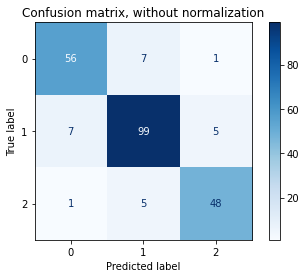

Normalized confusion matrix
[[0.875      0.109375   0.015625  ]
 [0.06306306 0.89189189 0.04504505]
 [0.01851852 0.09259259 0.88888889]]


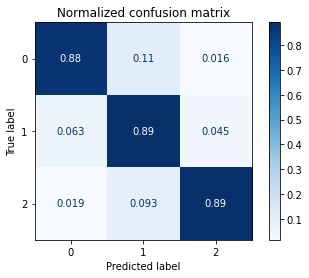

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot non-normalized confusion matrix
class_names= [0,1,2]
import matplotlib.pyplot as plt2
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_x_feature, Test_Y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.show()

In [ ]:
def get_prediction(sent):
    # corrected_query = spell_check(sent.lower())
    # if corrected_query != sent.lower() :
        # sent  = corrected_query
        # print("** Spell correction ** = ", corrected_query)
    # sent = process(sent)
    # test_vec = tv.transform([sent])
    test_vec = model.encode(sent)
    # SVM.predict(test_vec)

    class_value = clf.predict(test_vec)
    # prob = clf.predict_proba(test_vec)[0][class_value[0]]
    print("Calss_value = ", class_value)
    print("Predicted Class = ", Encoder.inverse_transform(class_value)[0])
    # print("Probabilty  = ", prob)

In [ ]:
sent = ["There are few things which I didnt add in my Goal settings and which i spent lots of work to complete and manger not highlited things on revieweal. Need to review my performance review from HR side also.",
       "attitude of the previous manager, he is self obsessed and think the whole system is running because of him.",
     "As of now nothing, it is already taken care by the management and the reporting boss",
    "In most cases he redirect us to speak to the manager with hearing to what we have to say. In the last 12 months, I have only had 1 skip level meeting that lasted for 10 minutes. When trying to raise a concern it was told to speak to manager directly",
      "Due to work from home its really becoming challenging. Working hours are becoming challenge to maintain work life balance. Getting no motivation from direct managers." ,
       "Covid has totally changed the work culture and life style of people. I think the kind of knowledge sharing and bonding between the team members have reduced now. Also it becomes very difficult to draw boundary between work and personal timings. We can think of something which can help in these aspects."]

for s in sent:
  print("INPUT : ", s)
  sent = process(s)
  get_prediction([s])
  print("#"*30)

INPUT :  best boos to work with
Calss_value =  [1]
Predicted Class =  manager
##############################
INPUT :  Popular Brand good work culture
Calss_value =  [1]
Predicted Class =  manager
##############################
INPUT :  no flexibility in work
Calss_value =  [2]
Predicted Class =  stress
##############################
